# Helper functions

In [1]:

import numpy as np

import d6tflow
import sklearn.datasets, sklearn.ensemble, sklearn.linear_model

from pathlib import Path

Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.


Welcome to d6tflow! For Q&A see https://github.com/d6t/d6tflow


In [2]:
d6tflow.settings.dirpath

WindowsPath('data')

# d6tflow Transformer (NodeTransformer)
> a d6tflow wrapper for a sklearn estimator

In [3]:
from pathlib import Path
import os
from warnings import warn

import d6tflow
from pathlib import Path
from collections import defaultdict

from sklearn.base import BaseEstimator

import cloudpickle

In [244]:
def camelize(s):
    if(len(s) == 0):
        return
    s1 = ''
    s1 += s[0].upper()        
    
    for i in range(1, len(s)):
        
        if not s[i].isalnum():
            s1 += ''
            i += 1                    
        elif (s[i] == ' '):
            s1 += s[i + 1].upper()
            i += 1
        elif(s[i - 1] != ' '):
            s1 += s[i]                
        
    while True:
        if s1[0].isnumeric():
            s1 = s1[1:] + s1[0]            
        else:
            break
            
    return s1    

def is_camel_case(s):    
    return (camelize(s) == s) and (s != '')

# Classes

In [246]:

    
class PicklerTransformer(Pickler, BaseEstimator):
    '''
    Sklearn verstion of Pickler
    during fit, pickles a dict containing X, y and kwargs passed to fit
    on trnsform, unpickles and returns the dict
    '''
    def __init__(self, name, override_on_fit = False):
        self.override_on_fit = override_on_fit
        super().__init__(name)
        return
    
    def fit(self, X, y = None, **kwargs):
        output_dict = {'X':X, 'y':y, 'kwargs':kwargs}        
        self.pickle(output_dict, override = self.override_on_fit)
        self.is_fitted_ = True
        return self
    
    def transform(self, X = None, **kwargs):
        return self.unpickle()
    
    def reset(self,):
        super().reset()
        self.is_fitted_ = False
        return self

# Task Factories

# Wrappers
> make to main wrappers: Skleaern way and keras way

# PipelineSession

# Serialization functionalities

# Model


===== Luigi Execution Summary =====

Scheduled 16 tasks of which:
* 16 ran successfully:
    - 1 X__Input1()
    - 1 X__Input2()
    - 1 X__Input3()
    - 1 fit__Concat1()
    - 1 fit__Concat2()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====




===== Luigi Execution Summary =====

Scheduled 17 tasks of which:
* 17 ran successfully:
    - 1 X__Input1()
    - 1 X__Input2()
    - 1 X__Input3()
    - 1 fit__Concat1()
    - 1 fit__Concat2()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



array([  8.99347384, -25.46939179, -18.29578307,  -9.14520322,
         4.49673692, -12.73469589,  -9.14789153,   4.49673692,
       -12.73469589,  -9.14789153,   4.49673692, -12.73469589,
        -9.14789153])

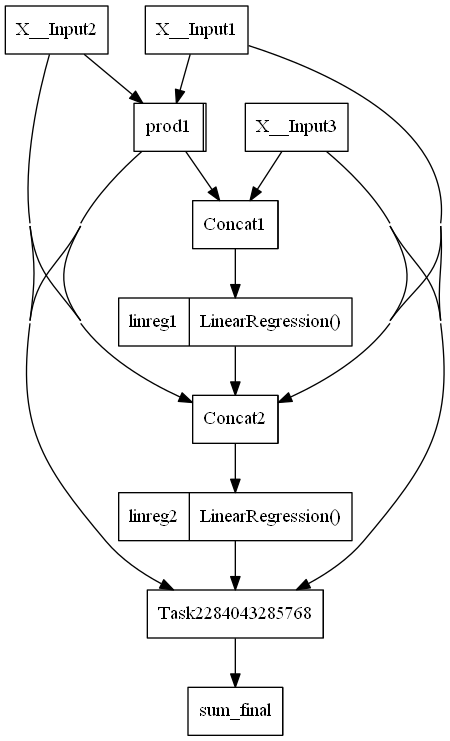

In [534]:
dag.show_dot()

In [ ]:
#TODO: reset cache during fit and transform